In [8]:
#!pip install transformers torch torchvision einops timm peft sentencepiece flash_attn

In [55]:
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig

In [55]:
# Load the model and tokenizer
model_path = 'h2oai/h2ovl-mississippi-800m'
# model_path = 'h2oai/h2ovl-mississippi-2b'

config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
# Disable flash attention
config.vision_config.use_flash_attn = False

model = AutoModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    config=config,
    low_cpu_mem_usage=True,
    trust_remote_code=True
).eval().cuda()

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)

# Generation configuration for model
generation_config = dict(max_new_tokens=500, do_sample=False)

In [59]:
def parse_json_response(response):
    """
    Extract JSON object from a response string using regular expressions.
    Assumes the response contains a JSON object that follows the format {"type": ""}.
    If model only returns a single word, then it will be converted to {"type": response}
    """
    try:
        # Use regular expression to find the JSON object in the string
        json_match = re.search(r'\{.*?\}', response)
        if json_match:
            json_str = json_match.group(0)
            return json.loads(json_str)
        elif len(response.strip().split(" ")) == 1:
            return {"type": response.strip()}
        else:
            print(f"Could not find valid JSON in response: {response}")
            return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON from response: {response}")
        return None

def evaluate_model(model, tokenizer, generation_config, files, prompt):
    actual_labels = []
    predicted_labels = []
    
    for image_file, true_label in files:
        response, history = model.chat(tokenizer, image_file, prompt, generation_config, history=None, return_history=True)
        
        parsed_response = parse_json_response(response)
        #print("parsed_response: ", parsed_response)
        if parsed_response and "type" in parsed_response:
            predicted_type = parsed_response["type"]
        else:
            predicted_type = ""  # Handle cases where parsing fails or JSON is incomplete
        
        actual_labels.append(true_label)
        predicted_labels.append(predicted_type)
    
    accuracy = accuracy_score(actual_labels, predicted_labels)
    conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=["invoice", "news-article", "resume"])
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    
    conf_df = pd.DataFrame(conf_matrix, index=["invoice", "news-article", "resume"], columns=["invoice", "news-article", "resume"])
    
    return accuracy, conf_df

def load_image_from_file(image_file):
    return Image.open(image_file).convert("RGB")

def plot_images_with_labels(files, images_per_row=5):
    """
    Plots the given images in a grid, with their categories labeled on top.
    
    Parameters:
    - files: A list of tuples where each tuple contains (file_path, label)
    - images_per_row: Number of images to display per row in the grid (default is 5)
    """
    num_rows = (len(files) + images_per_row - 1) // images_per_row

    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(20, 4 * num_rows))
    axs = axs.flatten()

    for i, (image_file, label) in enumerate(files):
        image = load_image_from_file(image_file)        
        axs[i].imshow(image)        
        axs[i].axis('off')
        axs[i].text(10, 10, label, color='red', fontsize=15, weight='bold', backgroundcolor='white')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

In [57]:
# List of files with their categories
files = [
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000036371.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000044003.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000080966.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000080967.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000113780.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000002844.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000011128.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000039666.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000081773.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000087166.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000000869.tif", "resume"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000566434.tif", "resume"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000279204.tif", "resume"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000157511.tif", "resume"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000279241.tif", "resume"),
]

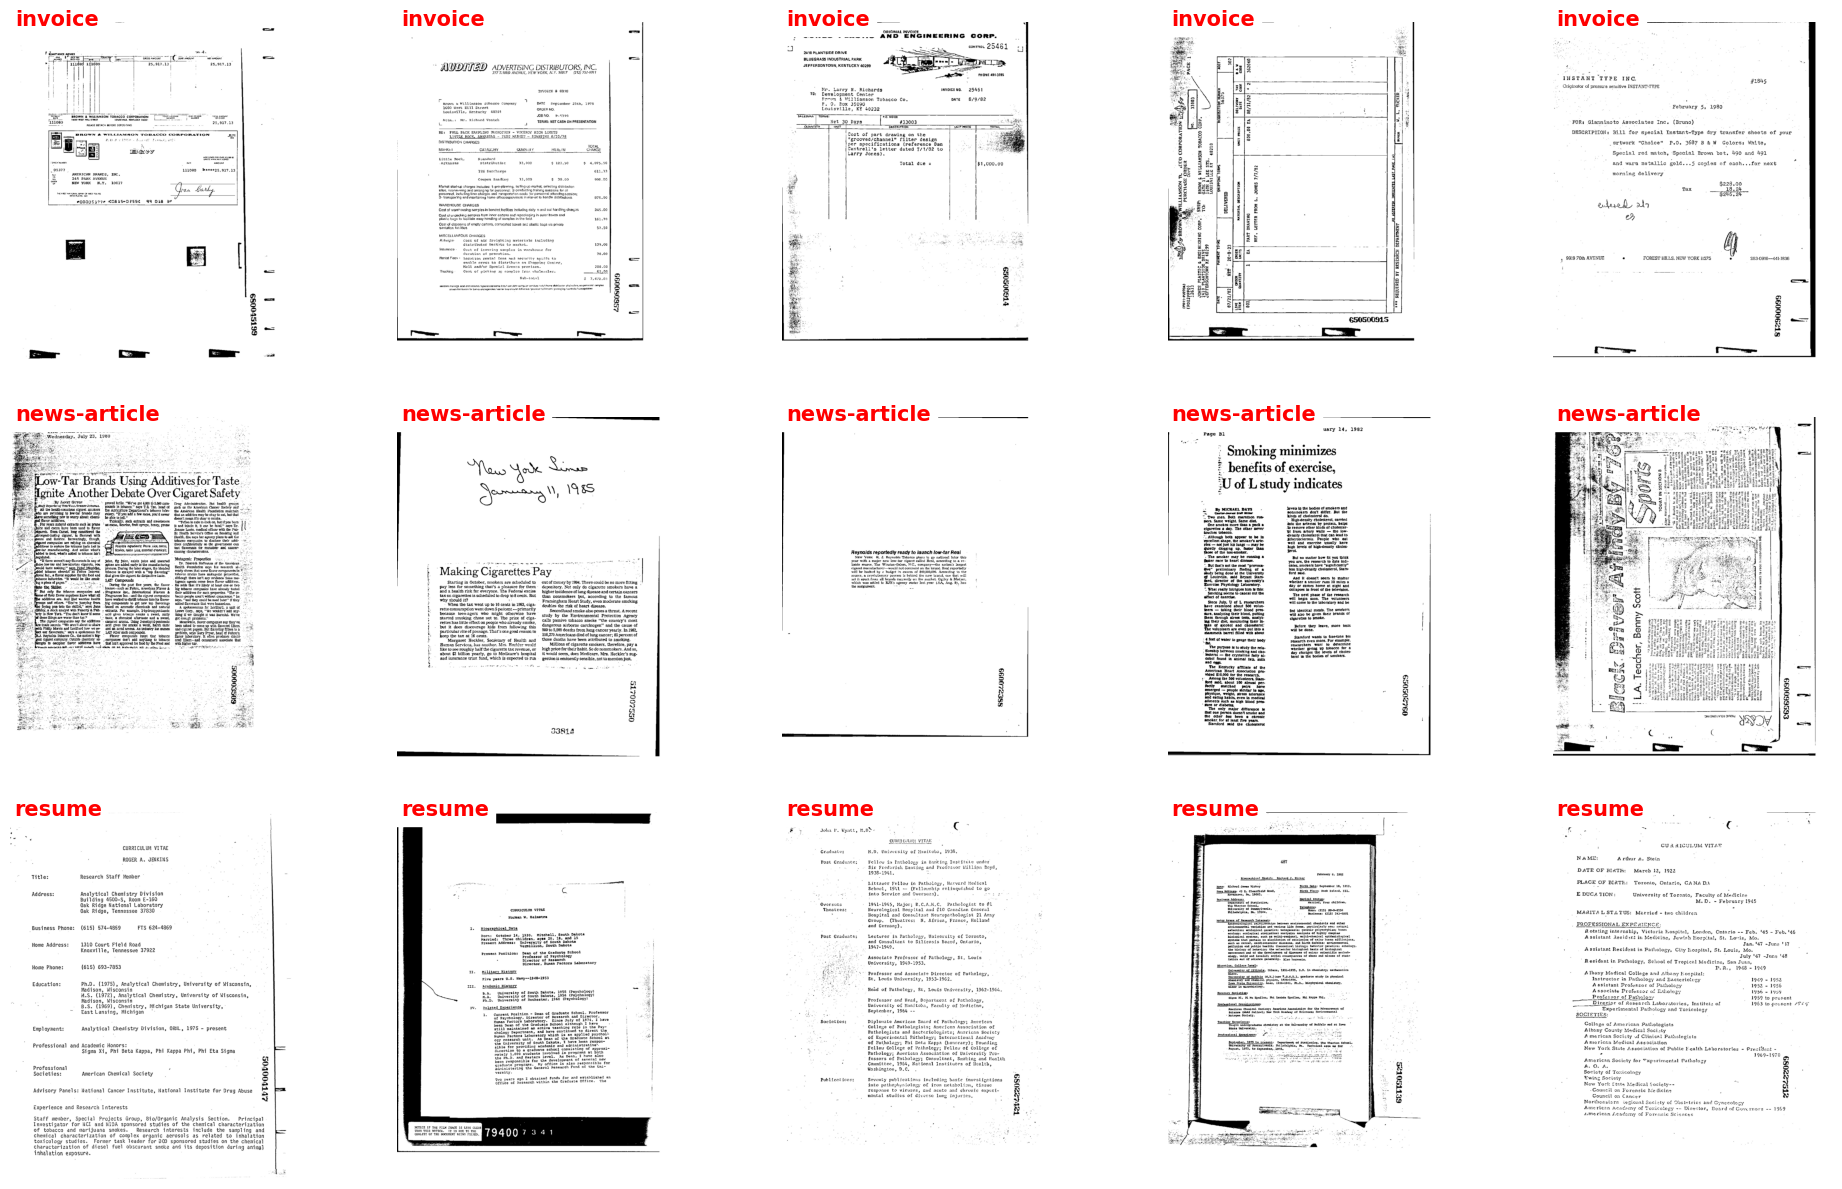

In [60]:
plot_images_with_labels(files, 5)

In [61]:
prompt = """<image>\nExtract the type of the image, categorizing it as 'invoice', 'resume', or 'news-article'. Type: """


accuracy, confusion_df = evaluate_model(model, tokenizer, generation_config, files, prompt)
print(confusion_df)

Accuracy: 100.00%
Confusion Matrix:
              invoice  news-article  resume
invoice             5             0       0
news-article        0             5       0
resume              0             0       5
